In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## Read HDF file and phenotypes

In [2]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


(30, 75)

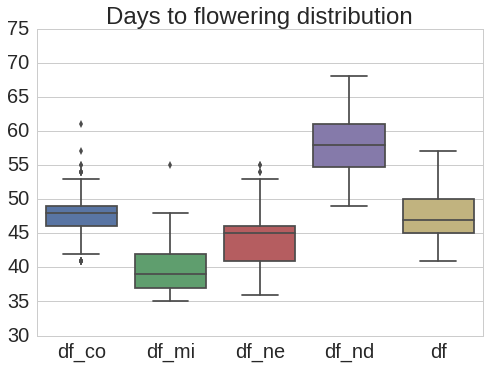

In [3]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
sns.boxplot(data=pheno_all[['df_co', 'df_mi', 'df_ne','df_nd', 'df']])
plt.title('Days to flowering distribution')
plt.ylim((30, 75))

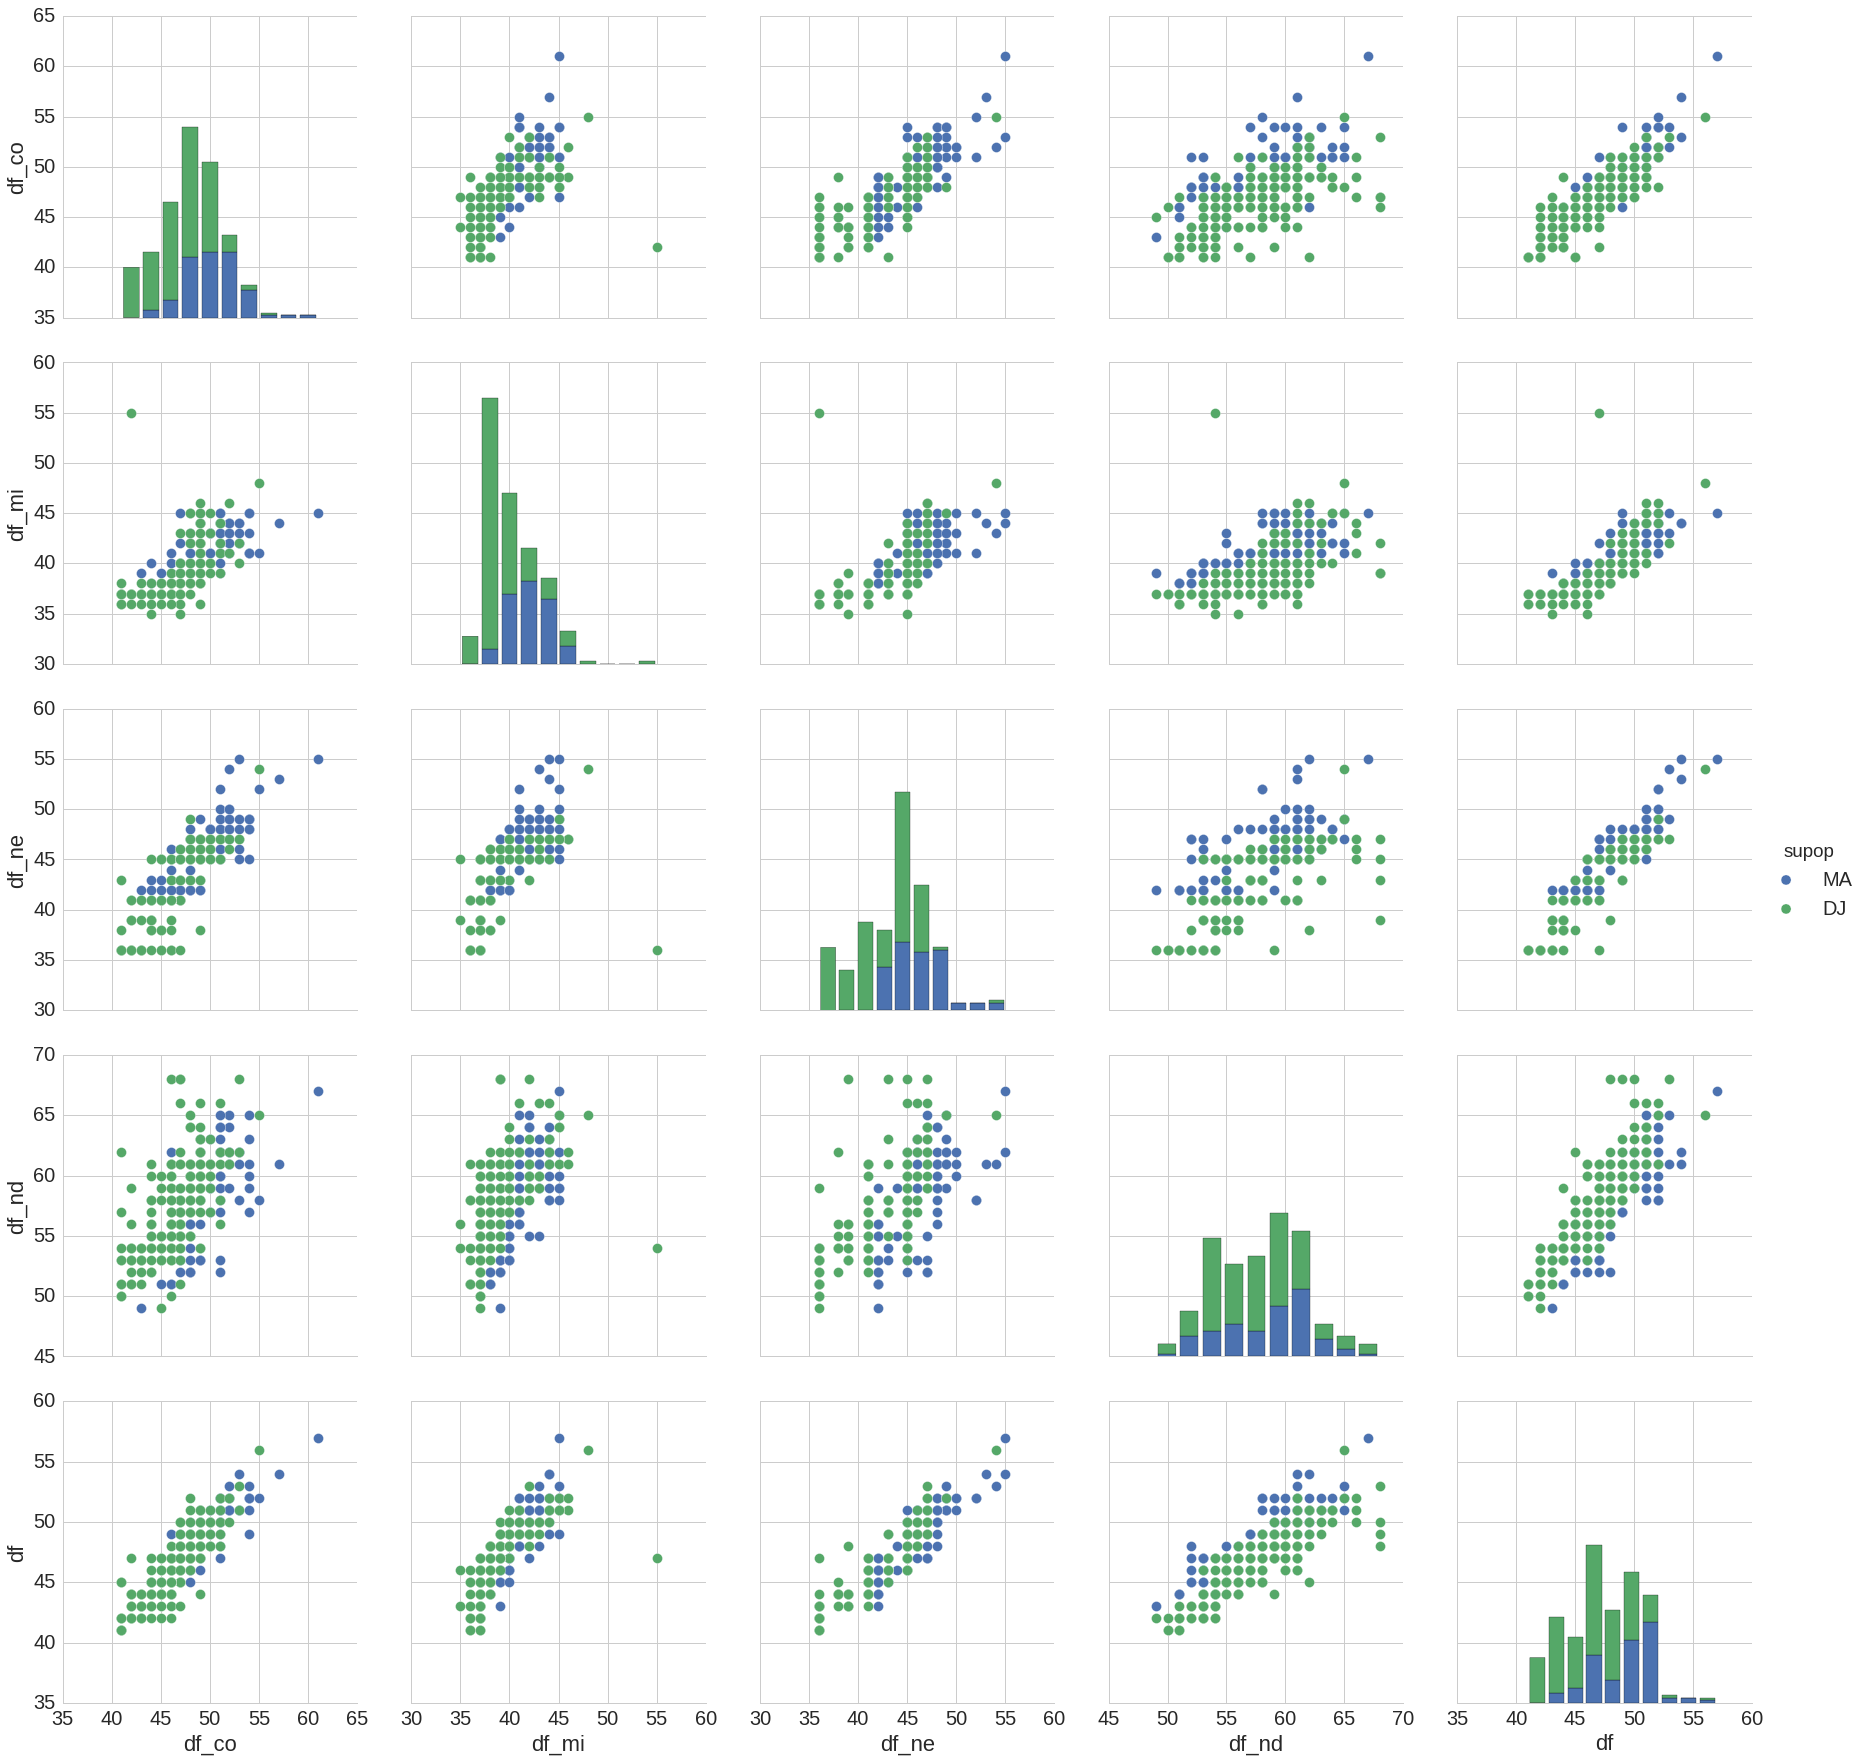

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df_co', 'df_mi', 'df_ne','df_nd', 'df', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

# Hyperparameter optimization across locations with different models
For datasets with more features than samples, like genotyping data, I will compare different models that are able to identify the most important features (SNPs) for phenotype prediction. For the current analysis I will compare 3 different models:

1. **ElasticNet**: use a hybrid L1/L2 regularization parameter

2. **LASSO**: use a L1 regularization parameter

3. **Random Forest**: Select feature importance based on multiple Decision Trees

I will optimize the hyperparameter on averaged phenotypes

## Train/Test data preparation

In [5]:
from sklearn.model_selection import train_test_split
X = final_SNPs.values
y = pheno_all['df'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20, random_state=101)

# initialize lists for creating a DF later
MAE = []
R2 = []
PCC = []

## ElasticNET

{'l1_ratio': 0.25176647008168951, 'alpha': 0.94042312561756303}
ElasticNet(alpha=0.94042312561756303, copy_X=True, fit_intercept=True,
      l1_ratio=0.25176647008168951, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=101,
      selection='random', tol=0.0001, warm_start=False)


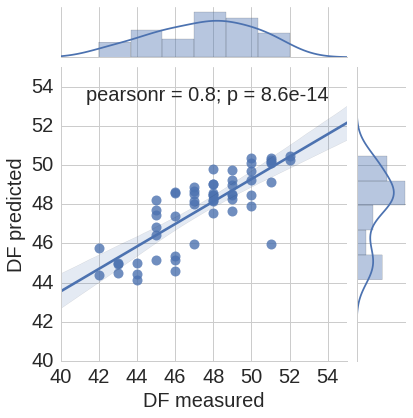

In [6]:
from sklearn.linear_model import ElasticNet
param_dist = {'l1_ratio':stats.uniform(0.1, 0.89),
              'alpha' : stats.reciprocal(0.1, 4)}



EN = ElasticNet(selection='random', random_state=101)

en_search_param = RandomizedSearchCV(EN, param_distributions=param_dist,
                             iid = False, cv = 10, scoring='neg_mean_absolute_error', n_iter=20,
                             random_state=42, n_jobs = -1)



en_search_param.fit(X_train, y_train)
print(en_search_param.best_params_)
print(en_search_param.best_estimator_)

y_pred = en_search_param.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred))

g = sns.jointplot(y_test, y_pred, kind="reg", scatter_kws={'s':100})
plt.xlabel('DF measured', fontsize=20)
plt.ylabel('DF predicted', fontsize=20)
plt.xlim((40, 55))
plt.ylim((40, 55))
plt.show()

## Lasso

{'alpha': 0.21886685320125282}
Lasso(alpha=0.21886685320125282, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=101, selection='random', tol=0.0001, warm_start=False)


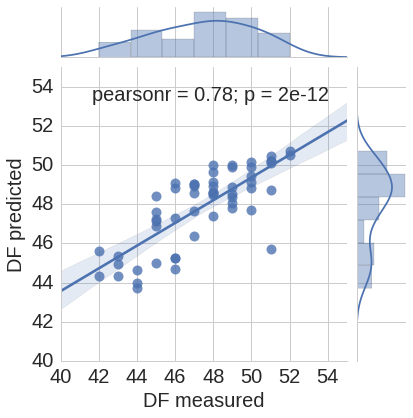

In [7]:
from sklearn.linear_model import Lasso
param_dist = {'alpha' : stats.reciprocal(0.1, 4)}

lasso = Lasso(selection='random', random_state=101)

lasso_search_param = RandomizedSearchCV(lasso, param_distributions=param_dist,
                             iid = False, cv = 10, scoring='neg_mean_absolute_error', n_iter=20,
                             random_state=42, n_jobs = -1)


lasso_search_param.fit(X_train, y_train)
print(lasso_search_param.best_params_)
print(lasso_search_param.best_estimator_)

y_pred = lasso_search_param.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred))

g = sns.jointplot(y_test, y_pred, kind="reg", scatter_kws={'s':100})
plt.xlabel('DF measured', fontsize=20)
plt.ylabel('DF predicted', fontsize=20)
plt.xlim((40, 55))
plt.ylim((40, 55))
plt.show()

## Random Forest

{'max_features': 0.46466020103939104, 'min_samples_leaf': 4, 'n_estimators': 59, 'max_depth': 36}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=36,
           max_features=0.46466020103939104, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)


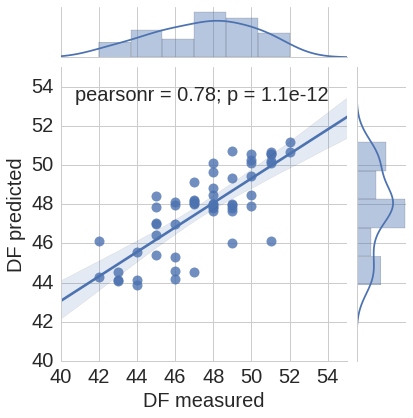

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(oob_score=True, random_state=42)

param_dist = {'max_features':stats.uniform(0.01, 0.5),
              'n_estimators': stats.randint(10, 500),
              'min_samples_leaf':stats.randint(1, 30),
              'max_depth':stats.randint(2, 50)
             }


rf_searc = RandomizedSearchCV(rf, param_distributions=param_dist,
                             iid = False, cv = 10, scoring='neg_mean_absolute_error', n_iter=20,
                             random_state=42, n_jobs = -1)

rf_searc.fit(X_train, y_train)
print(rf_searc.best_params_)
print(rf_searc.best_estimator_)

y_pred = rf_searc.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred))

g = sns.jointplot(y_test, y_pred, kind="reg", scatter_kws={'s':100})
plt.xlabel('DF measured', fontsize=20)
plt.ylabel('DF predicted', fontsize=20)
plt.xlim((40, 55))
plt.ylim((40, 55))
plt.show()

## Evaluate Accuracy of the models

In [9]:
scores_table = pd.DataFrame({'MAE':MAE, 'R2':R2, 'PCC':[col[0] for col in PCC]},
                           columns = ['MAE', 'R2', 'PCC'],
                           index = ['ElasticNet', 'LASSO', 'Random Forest'])
scores_table

,MAE,R2,PCC
ElasticNet,1.276799,0.618055,0.803946
LASSO,1.356008,0.574529,0.776477
Random Forest,1.297245,0.601161,0.782452


 	MAE 	R2 	PCC
ElasticNet 	1.276799 	0.618055 	0.803946
LASSO 	1.356008 	0.574529 	0.776477
Random Forest 	1.297245 	0.601161 	0.782452

# Multi Environment testing

For multienvironment testing I will utilize the hyperparameters obtained from average phenotypes
I will retrain the model in multiple environments. I will reload the different environments phenotypes and evaluate them.

In [10]:
df_data_all = pheno_all[['df_co', 'df_mi', 'df_ne','df_nd', 'df']]
pheno_areas = df_data_all.drop('df', axis = 1)
pheno_areas.head()

,df_co,df_mi,df_ne,df_nd
0,49,41,47,59
1,46,38,45,59
2,49,44,45,60
3,46,38,41,56
4,51,45,52,58


## Train/Test data preparation

In [11]:
X = final_SNPs.values

y = pheno_areas.values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20, random_state=101)

MAE_MultiENV = []
R2_MultiENV = []
PCC_MultiENV = []

## Prepare_models
I will load new models with the hyperparameter already optimized from averaged phenotypes.
Scikit-learn handle also multi-phenotypes output, thus with a single fit I can fit in multiple environments 

In [12]:
# EN
en = en_search_param.best_estimator_

# LASSO
lasso = lasso_search_param.best_estimator_

# RF

rf = rf_searc.best_estimator_

## ElasticNet

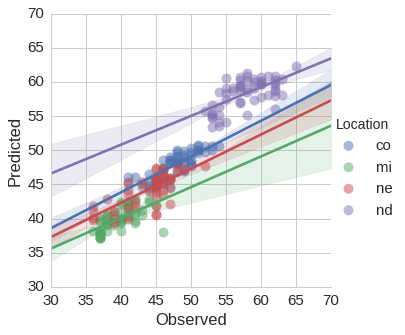

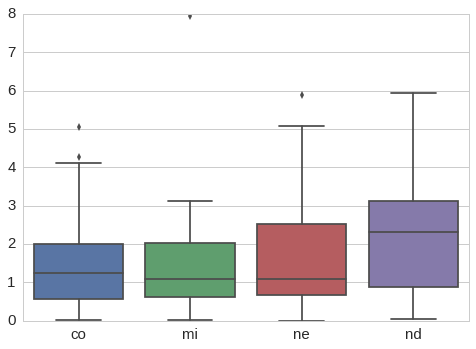

In [13]:
from sklearn.multioutput import MultiOutputRegressor
multi_en = MultiOutputRegressor(estimator = en)
multi_en.fit(X_train, y_train)

y_pred = multi_en.predict(X_test)
MAE_MultiENV.append(mean_absolute_error(y_test, y_pred))
R2_MultiENV.append(r2_score(y_test, y_pred))
PCC_MultiENV.append(pearsonr(np.reshape(y_test, -1, 1), np.reshape(y_pred, -1, 1)))

y_pred_lin = np.reshape(y_pred, -1, 1)
y_test_lin = np.reshape(y_test, -1, 1)
locations = np.repeat(['co', 'mi', 'ne', 'nd'], y_pred.shape[0])

data_pred = pd.DataFrame({'Observed': y_test_lin, 'Predicted': y_pred_lin, 
                         'Location':locations}, 
                         columns=['Observed', 'Predicted', 'Location'])

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.lmplot(x='Observed', y = 'Predicted', hue = 'Location', data = data_pred, 
          scatter_kws={'s':100, 'alpha':0.5})
plt.show()
list_of_diff = np.abs(np.subtract(y_test, y_pred))
MAE_db = pd.DataFrame(list_of_diff, columns=['co', 'mi', 'ne', 'nd'])
sns.boxplot(data=MAE_db)
plt.show()

## LASSO

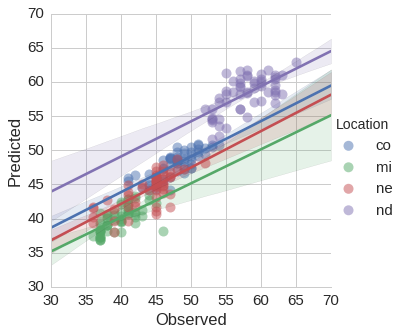

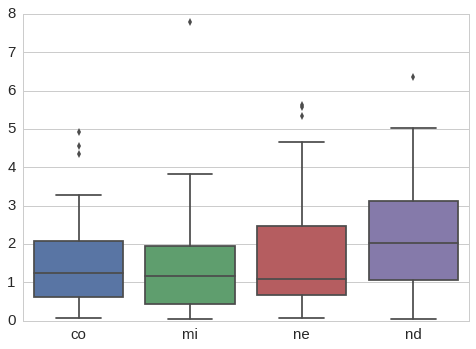

In [14]:
multi_lasso = MultiOutputRegressor(estimator = lasso)

multi_lasso.fit(X_train, y_train)
y_pred = multi_lasso.predict(X_test)
MAE_MultiENV.append(mean_absolute_error(y_test, y_pred))
R2_MultiENV.append(r2_score(y_test, y_pred))
PCC_MultiENV.append(pearsonr(np.reshape(y_test, -1, 1), np.reshape(y_pred, -1, 1)))


y_pred_lin = np.reshape(y_pred, -1, 1)
y_test_lin = np.reshape(y_test, -1, 1)
locations = np.repeat(['co', 'mi', 'ne', 'nd'], y_pred.shape[0])

data_pred = pd.DataFrame({'Observed': y_test_lin, 'Predicted': y_pred_lin, 
                         'Location':locations}, 
                         columns=['Observed', 'Predicted', 'Location'])

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.lmplot(x='Observed', y = 'Predicted', hue = 'Location', data = data_pred, 
          scatter_kws={'s':100, 'alpha':0.5})
plt.show()
list_of_diff = np.abs(np.subtract(y_test, y_pred))
MAE_db = pd.DataFrame(list_of_diff, columns=['co', 'mi', 'ne', 'nd'])
sns.boxplot(data=MAE_db)
plt.show()

## Random Forest

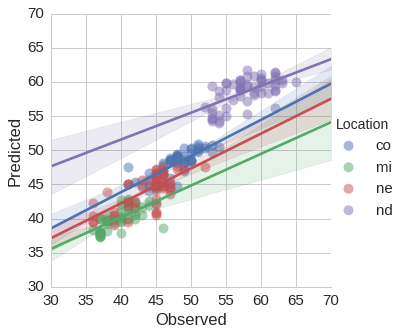

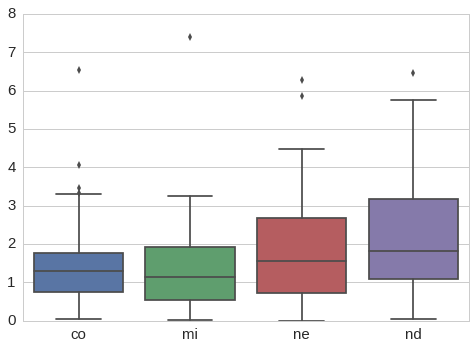

In [15]:
from sklearn.multioutput import MultiOutputRegressor

multi_rf = MultiOutputRegressor(estimator = rf)

multi_rf.fit(X_train, y_train)
y_pred = multi_rf.predict(X_test)
MAE_MultiENV.append(mean_absolute_error(y_test, y_pred))
R2_MultiENV.append(r2_score(y_test, y_pred))
PCC_MultiENV.append(pearsonr(np.reshape(y_test, -1, 1), np.reshape(y_pred, -1, 1)))


y_pred_lin = np.reshape(y_pred, -1, 1)
y_test_lin = np.reshape(y_test, -1, 1)
locations = np.repeat(['co', 'mi', 'ne', 'nd'], y_pred.shape[0])

data_pred = pd.DataFrame({'Observed': y_test_lin, 'Predicted': y_pred_lin, 
                         'Location':locations}, 
                         columns=['Observed', 'Predicted', 'Location'])

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.lmplot(x='Observed', y = 'Predicted', hue = 'Location', data = data_pred, 
          scatter_kws={'s':100, 'alpha':0.5})
plt.show()
list_of_diff = np.abs(np.subtract(y_test, y_pred))
MAE_db = pd.DataFrame(list_of_diff, columns=['co', 'mi', 'ne', 'nd'])
sns.boxplot(data=MAE_db)
plt.show()

## Combined

Average of the different prediction algorithms and comparison with observed phenotypes

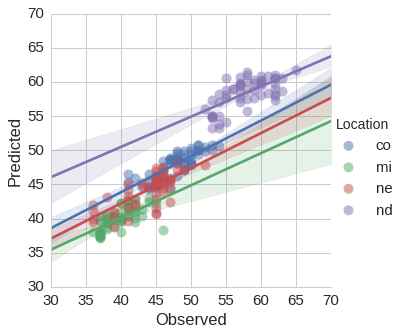

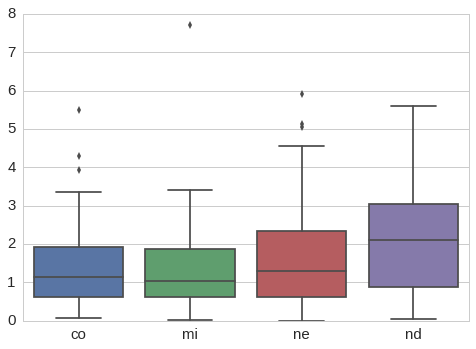

In [16]:
y_pred_en = multi_en.predict(X_test)
y_pred_lasso = multi_lasso.predict(X_test)
y_pred_rf = multi_rf.predict(X_test)

y_pred_avg = np.mean(np.array([y_pred_en, y_pred_lasso, y_pred_rf]), axis=0)
MAE_MultiENV.append(mean_absolute_error(y_test, y_pred_avg))
R2_MultiENV.append(r2_score(y_test, y_pred_avg))
PCC_MultiENV.append(pearsonr(np.reshape(y_test, -1, 1), np.reshape(y_pred, -1, 1)))


y_pred_lin = np.reshape(y_pred_avg, -1, 1)
y_test_lin = np.reshape(y_test, -1, 1)
locations = np.repeat(['co', 'mi', 'ne', 'nd'], y_pred_avg.shape[0])

data_pred = pd.DataFrame({'Observed': y_test_lin, 'Predicted': y_pred_lin, 
                         'Location':locations}, 
                         columns=['Observed', 'Predicted', 'Location'])

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.lmplot(x='Observed', y = 'Predicted', hue = 'Location', data = data_pred, 
          scatter_kws={'s':100, 'alpha':0.5})
plt.show()
list_of_diff = np.abs(np.subtract(y_test, y_pred_avg))
MAE_db = pd.DataFrame(list_of_diff, columns=['co', 'mi', 'ne', 'nd'])
sns.boxplot(data=MAE_db)
plt.show()

## Compare scores

In [17]:
scores_table = pd.DataFrame({'MAE':MAE_MultiENV, 'R2':R2_MultiENV, 
                             'PCC':[col[0] for col in PCC_MultiENV]},
                            columns = ['MAE', 'R2', 'PCC'],
                            index = ['ElasticNet', 'LASSO', 'Random Forest', 'Combined'])
scores_table

,MAE,R2,PCC
ElasticNet,1.679143,0.473663,0.956134
LASSO,1.700550,0.469243,0.955831
Random Forest,1.727890,0.459638,0.955155
Combined,1.663817,0.490936,0.955155


In [35]:
for i in range(np.shape(y_test)[1]):
    print(mean_absolute_error(y_test[:,i], y_pred_avg[:,i]))

1.42102751808
1.36090396819
1.76113251989
2.11220341773


In [36]:
for i in range(np.shape(y_test)[1]):
    print(pearsonr(y_test[:,i], y_pred_avg[:,i]))

(0.80287100525073918, 9.8677252709738641e-14)
(0.66399842291436728, 2.4241553412121881e-08)
(0.73304794983255284, 1.3296498655868143e-10)
(0.65521361663066668, 4.2705479797142086e-08)


In [37]:
for i in range(np.shape(y_test)[1]):
    print(pearsonr(y_test[:,i], y_pred_avg[:,i]))

(0.80287100525073918, 9.8677252709738641e-14)
(0.66399842291436728, 2.4241553412121881e-08)
(0.73304794983255284, 1.3296498655868143e-10)
(0.65521361663066668, 4.2705479797142086e-08)


In [38]:
for i in range(np.shape(y_test)[1]):
    print(pearsonr(y_test[:,i], y_pred_avg[:,i]))

(0.80287100525073918, 9.8677252709738641e-14)
(0.66399842291436728, 2.4241553412121881e-08)
(0.73304794983255284, 1.3296498655868143e-10)
(0.65521361663066668, 4.2705479797142086e-08)
